# Multi objective Sequence to Sequence model

In [0]:
!wget http://www.manythings.org/anki/fra-eng.zip
!sudo apt-get install unzip
!unzip fra-eng.zip
%rm fa.txt
!wget https://raw.githubusercontent.com/iamdanialkamali/iust-deep-learning-assignments/master/fa.txt
!ls

--2019-12-29 10:40:01--  http://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.24.109.196, 104.24.108.196, 2606:4700:30::6818:6cc4, ...
Connecting to www.manythings.org (www.manythings.org)|104.24.109.196|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5800008 (5.5M) [application/zip]
Saving to: ‘fra-eng.zip.1’

fra-eng.zip.1       100%[===================>]   5.53M  1.26MB/s    in 4.4s    

2019-12-29 10:40:06 (1.26 MB/s) - ‘fra-eng.zip.1’ saved [5800008/5800008]

Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-21ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 19 not upgraded.
Archive:  fra-eng.zip
replace _about.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: _about.txt 

In [0]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64  # Batch size for training.
epochs = 10  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra.txt'
farsi_path = 'fa.txt'
!ls

_about.txt  asg03  downloads  fa.txt  fra-eng.zip  fra.txt  sample_data


In [0]:
# Vectorize the data.
input_file = open(data_path).readlines()[:num_samples]
farsi_file = open(farsi_path).readlines()[:num_samples]
english_texts = [i.split('\t')[0].strip() for i in input_file  ]
farsi_texts = ["\t" + i.strip() + "\n" for i in farsi_file  ]
french_texts = ["\t" + i.split('\t')[1].strip() + "\n" for i in input_file]
english_characters = set()
french_characters = set()
farsi_characters = set()
[[english_characters.add(j) for j in list(i) ]for i in english_texts]
[[french_characters.add(j) for j in list(i) ]for i in french_texts]
[[farsi_characters.add(j) for j in list(i) ]for i in farsi_texts]
num_english_tokens = len(english_characters)
num_french_decoder_tokens = len(french_characters)
num_farsi_decoder_tokens = len(farsi_characters)
max_english_seq_length = len(english_texts[-1])
max_french_decoder_seq_length = max(list(map(len,french_texts)))
max_farsi_decoder_seq_length = max(list(map(len,farsi_texts)))
print(english_characters)

{'W', 'j', 'S', 'a', 'm', 'D', 'O', 'Y', '5', 'b', '6', 'u', 'T', 'c', 'f', 'E', "'", 'N', '&', ':', '?', 'r', ' ', 'i', 'h', '$', 'g', 'V', 'L', 'B', 'v', 'M', 'H', 't', 'k', 'U', 'q', '3', 'y', 'w', 'C', 'p', ',', 'P', 'e', '-', '9', '0', 'o', 'z', 'd', 'R', 's', 'G', 'J', 'x', '.', 'l', 'K', '8', '2', '%', 'F', 'I', '7', '1', 'n', 'Q', '!', 'A'}


In [0]:
english_token_index = dict(
    [(char, i) for i, char in enumerate(english_characters)])
french_target_token_index = dict(
    [(char, i) for i, char in enumerate(french_characters)])
farsi_target_token_index = dict(
    [(char, i) for i, char in enumerate(farsi_characters)])

w = [[english_token_index[char]  for char in list(word) ] for word in english_texts]
f = []
for word in w :
  www = [[0]* num_english_tokens]*max_english_seq_length
  for i,char in enumerate(word):
    ww = [0]* num_english_tokens
    ww[char] = 1
    www[i] = np.array(ww[:])
  f.append(np.array(www[:]))
english_input_data = np.array(f)

w = [[french_target_token_index[char]  for char in list(word)[:-1] ] for word in french_texts]
f = []
for word in w :
  www = [[0]* num_french_decoder_tokens]*max_french_decoder_seq_length
  for i,char in enumerate(word):
    ww = [0]* num_french_decoder_tokens
    ww[char] = 1
    www[i] = np.array(ww[:])
  f.append(np.array(www[:]))
french_input_data = np.array(f)

w = [[farsi_target_token_index[char]  for char in list(word)[:-1] ] for word in farsi_texts]
f = []
for word in w :
  www = [[0]* num_farsi_decoder_tokens]*max_farsi_decoder_seq_length
  for i,char in enumerate(word):
    ww = [0]* num_farsi_decoder_tokens
    ww[char] = 1
    www[i] = np.array(ww[:])
  f.append(np.array(www[:]))
farsi_input_data = np.array(f)


w = [[french_target_token_index[char]  for char in list(word)[1:] ] for word in french_texts]
f = []
for word in w :
  www = [[0]* num_french_decoder_tokens]*max_french_decoder_seq_length
  for i,char in enumerate(word):
    ww = [0]* num_french_decoder_tokens
    ww[char] = 1
    www[i] = np.array(ww[:])
  f.append(np.array(www[:]))
french_decoder_target_data = np.array(f)


w = [[farsi_target_token_index[char]  for char in list(word)[1:] ] for word in farsi_texts]
f = []
for word in w :
  www = [[0]* num_farsi_decoder_tokens]*max_farsi_decoder_seq_length
  for i,char in enumerate(word):
    ww = [0]* num_farsi_decoder_tokens
    ww[char] = 1
    www[i] = np.array(ww[:])
  f.append(np.array(www[:]))
farsi_decoder_target_data = np.array(f)



In [0]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,num_english_tokens ))
encoder = LSTM(latent_dim, return_state=True, return_sequences=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states =[state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
french_decoder_inputs = Input(shape=(None,  num_french_decoder_tokens))
farsi_decoder_inputs = Input(shape=(None,  num_farsi_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
french_decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
farsi_decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)

french_decoder_outputs, _, _ = french_decoder_lstm(french_decoder_inputs,
                                     initial_state=encoder_states)
french_decoder_dense = Dense(num_french_decoder_tokens, activation='softmax')
french_decoder_outputs = french_decoder_dense(french_decoder_outputs)

farsi_decoder_outputs, _, _ = farsi_decoder_lstm(farsi_decoder_inputs,
                                     initial_state=encoder_states)
farsi_decoder_dense = Dense(num_farsi_decoder_tokens, activation='softmax')
farsi_decoder_outputs = farsi_decoder_dense(farsi_decoder_outputs)


# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, french_decoder_inputs,farsi_decoder_inputs], [french_decoder_outputs,farsi_decoder_outputs])

# Run training
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([english_input_data, french_input_data,farsi_input_data], [french_decoder_target_data,farsi_decoder_target_data],
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

# Save model
model.save('s2s.h5')

Train on 8000 samples, validate on 2000 samples
Epoch 1/10
8000/8000 [==============================] - 25s 3ms/step - loss: 1.9270 - dense_35_loss: 0.9187 - dense_36_loss: 1.0083 - val_loss: 2.0442 - val_dense_35_loss: 0.9456 - val_dense_36_loss: 1.0986
Epoch 2/10
8000/8000 [==============================] - 23s 3ms/step - loss: 1.5868 - dense_35_loss: 0.7320 - dense_36_loss: 0.8548 - val_loss: 1.7092 - val_dense_35_loss: 0.7653 - val_dense_36_loss: 0.9439
Epoch 3/10
8000/8000 [==============================] - 22s 3ms/step - loss: 1.3815 - dense_35_loss: 0.6171 - dense_36_loss: 0.7644 - val_loss: 1.5649 - val_dense_35_loss: 0.6863 - val_dense_36_loss: 0.8786
Epoch 4/10
8000/8000 [==============================] - 22s 3ms/step - loss: 1.2715 - dense_35_loss: 0.5619 - dense_36_loss: 0.7096 - val_loss: 1.4530 - val_dense_35_loss: 0.6246 - val_dense_36_loss: 0.8284
Epoch 5/10
8000/8000 [==============================] - 22s 3ms/step - loss: 1.1867 - dense_35_loss: 0.5226 - dense_36_loss:

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_15 (InputLayer)           (None, None, 70)     0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, None, 93)     0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, None, 256),  334848      input_15[0][0]                   
__________________________________________________________________________________________________
input_17 (InputLayer)           (None, None, 89)     0                                            
____________________________________________________________________________________________

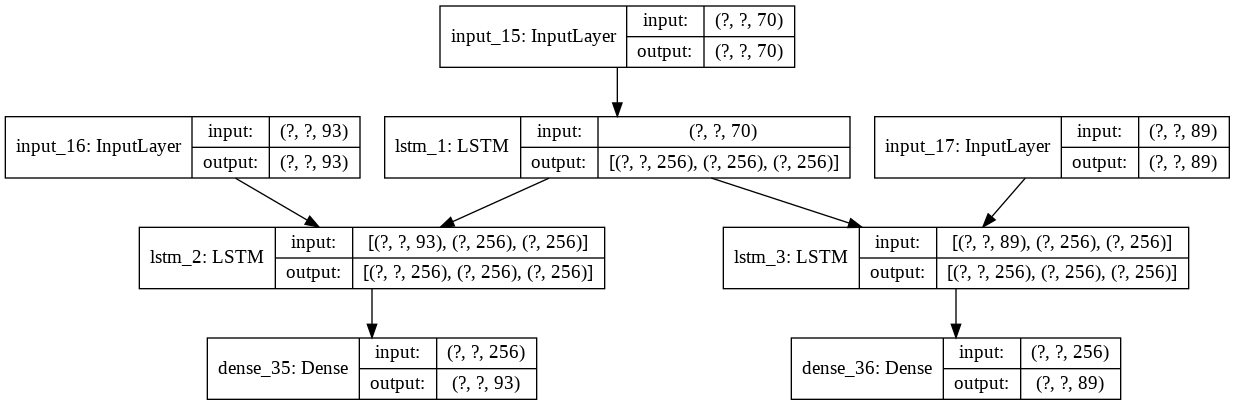

In [0]:
model.summary()
import tensorflow as tf
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)


In [0]:
# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

# Define sampling models
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
french_decoder_outputs, state_h, state_c = french_decoder_lstm(
    french_decoder_inputs, initial_state=decoder_states_inputs)
french_decoder_states = [state_h, state_c]
french_decoder_outputs = french_decoder_dense(french_decoder_outputs)
french_decoder_model = Model(
    [french_decoder_inputs] + decoder_states_inputs,
    [french_decoder_outputs] + french_decoder_states)


farsi_decoder_outputs, state_h, state_c = farsi_decoder_lstm(
    farsi_decoder_inputs, initial_state=decoder_states_inputs)
farsi_decoder_states = [state_h, state_c]
farsi_decoder_outputs = farsi_decoder_dense(farsi_decoder_outputs)
farsi_decoder_model = Model(
    [farsi_decoder_inputs] + decoder_states_inputs,
    [farsi_decoder_outputs] + farsi_decoder_states)



# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in english_token_index.items())

reverse_french_target_char_index = dict(
    (i, char) for char, i in french_target_token_index.items())

reverse_farsi_target_char_index = dict(
    (i, char) for char, i in farsi_target_token_index.items())


def decode_sequence_to_french(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_french_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, french_target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = french_decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_french_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_french_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_french_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]


    return decoded_sentence


def decode_sequence_to_farsi(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_farsi_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, farsi_target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = farsi_decoder_model.predict(
            [target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_farsi_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_farsi_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_farsi_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [h, c]


    return decoded_sentence



for seq_index in range(100):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    input_seq = english_input_data[seq_index: seq_index + 1]
    decoded_french_sentence = decode_sequence_to_french(input_seq)
    decoded_farsi_sentence = decode_sequence_to_farsi(input_seq)
    print('-')
    print('Input sentence:', english_texts[seq_index])
    print('Decoded french sentence:', decoded_french_sentence)
    print('Decoded farsi sentence:', decoded_farsi_sentence)


-
Input sentence: Go.
Decoded french sentence: Ve l'est parte !

Decoded farsi sentence: برو بروان بخوان.

-
Input sentence: Hi.
Decoded french sentence: Arrête de toir !

Decoded farsi sentence: برا بین.

-
Input sentence: Hi.
Decoded french sentence: Arrête de toir !

Decoded farsi sentence: برا بین.

-
Input sentence: Run!
Decoded french sentence: Va chez vous parte !

Decoded farsi sentence: برو بروان بخوان.

-
Input sentence: Run!
Decoded french sentence: Va chez vous parte !

Decoded farsi sentence: برو بروان بخوان.

-
Input sentence: Who?
Decoded french sentence: Qui l'a partir ?

Decoded farsi sentence: آنها آن را دوست دارید؟

-
Input sentence: Wow!
Decoded french sentence: Ve l'est parte !

Decoded farsi sentence: به من باش.

-
Input sentence: Fire!
Decoded french sentence: Arrête de toim !

Decoded farsi sentence: به من به ما بلان کن.

-
Input sentence: Help!
Decoded french sentence: Sous parte !

Decoded farsi sentence: برو بروان.

-
Input sentence: Jump.
Decoded french sent